In [140]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import re
from re import sub 

from datetime import timedelta

base_link = "https://www.themoviedb.org/movie"

def base_content_load(url):
    get_headers = {'User-Agent': "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36"}
    response_page = requests.get(url, headers = get_headers )f
    if not response_page.ok:
        raise Exception ("Failed to request. Status Code :- {}".format(response_page.status_code))
    else:
        page_content = response_page.text
        doc_page = BeautifulSoup(page_content, "html.parser")
        return doc_page
    
def movie_data_dict():
    scraped_dict = {  
                    'Title': [],
                    'User_rating': [], 
                    'Release_date':[], 
                    #'Director': [],
                    'Tagline': [],
                    'Runtime': [],
                    'Genre': [],
                    'Certification': [],
                    'Cast': [],
                    # 'Budget': [],
                    # 'Revenue': []
                    
                    }
    return scraped_dict

def user_rating(tag_user_score, i, scraped_dict):
    if tag_user_score[i]['data-percent'] == '0':
        scraped_dict['User_rating'].append('Not rated yet')
    else:
        scraped_dict['User_rating'].append(tag_user_score[i]['data-percent'])
        
def f_movie_info(doc_page):
    base_link_1 = "https://www.themoviedb.org"
    tag_title = tag_premired_date = tag_shows_page = doc_page.find_all('div', {'class': 'card style_1'}) #it saves all of the card style_1 
    tag_user_score = doc_page.find_all('div', {"user_score_chart"}) 
    
    doc_2_list = []
    for link in tag_shows_page:
        doc_2_list.append(base_content_load("https://www.themoviedb.org" + link.h2.a['href']))
    return tag_title, tag_user_score, doc_2_list
        
def movie_genres(doc2_page, i):
    genres_tags = doc2_page[i].find('span', {"class": "genres"}).find_all('a')
    check_genre =[]
    
    for tag in genres_tags:
        check_genre.append(tag.text)
    return check_genre
    
def tagline_info(doc_2_list, i, scraped_dict):
    if doc_2_list[i].find('h3',{"class": 'tagline'}):
        scraped_dict['Tagline'].append(doc_2_list[i].find('h3',{"class": 'tagline'}).text)
    else:
        scraped_dict['Tagline'].append("No Tagline")

def remove(string):
    '''
    Removes everything inside [], a whitespace before that and *'s.
    '''
    if isinstance(string, str):
        string = sub(r'\s*\[.*\]\**|\n|,', '', string)
    return string

def runtime_info(doc_2_list, i, scraped_dict):
    if doc_2_list[i].find('span',{"class": 'runtime'}):
        scraped_dict['Runtime'].append(remove(doc_2_list[i].find('span',{"class": 'runtime'}).text))
    else:
        scraped_dict['Runtime'].append("No Runtime")
        
'''
def director_info(doc_2_list, i, scraped_dict):
    if doc_2_list[i].find('a',{"herf"}):
        scraped_dict['Director'].append(doc_2_list[i].find('a',{"herf": "/person/35453-pierre-morel"}).text)
    else:
        scraped_dict['Director'].append("No Director")
'''
        
def movie_cast(doc2_page, i):
    cast_tags = doc2_page[i].find_all('li', {'class': 'card'})
    cast_lis = []
    
    for t in cast_tags:
         cast_lis.append(t.p.text)
    
    return cast_lis

def certification(doc_2_list, i, scraped_dict):
    if doc_2_list[i].find('span',{"class": 'certification'}):
        scraped_dict['Certification'].append(remove(doc_2_list[i].find('span',{"class": 'certification'}).text))
    else:
        scraped_dict['Certification'].append("No Certification")

def scrape_budget(docs):
    
    slots = docs.find(attrs={"class" : "column no_bottom_pad"})    
    budget_string = slots.find_all("p")[-2].text
    
    pattern = r'\d+'
    
    budget = re.findall(pattern, budget_string)

    if len(budget)!=0:        
        string_budget = "".join(budget)
        return int(string_budget)/100
    else:
        return "NA"

def scrape_revenue(docs):
    slots = docs.find(attrs={"class" : "column no_bottom_pad"})
    revenue_string = slots.find_all("p")[-1].text
     
    pattern = r'\d+'

    revenue = re.findall(pattern, revenue_string)

    if len(revenue)!=0:
        string_revenue = "".join(revenue)
        return int(string_revenue)/100
        
    else :
        return "NA"


def create_budget_revenue_df(i, base_link):

    next_url = base_link + '?page={}'.format(i)
    doc_top = base_content_load(next_url)
    _, _, doc_2_lis = f_movie_info(doc_top)

    # return doc_2_lis
    
    budget_revenue_dic = {"Budget":[],
                          "Revenue":[]}
    
    for i in range(0, len(doc_2_lis)):
        budget_revenue_dic["Budget"].append(scrape_budget(doc_2_lis[i]))
        budget_revenue_dic["Revenue"].append(scrape_revenue(doc_2_lis[i]))
        
    return pd.DataFrame(budget_revenue_dic)



def create_budget_revenue_csv(i, base_link):
    try:
        df = create_budget_revenue_df(i, base_link)
        df.to_csv(f"shows-data/revenue_budget_page_{i}.csv", index=None)
        print(f"CSV file for page {i} created successfully.")
    except Exception as e:
        print(f"An error occurred while creating CSV for page {i}: {e}")




def final_movie_details(t_title, t_user_score, docs_2_list):
    scraped_dict = movie_data_dict()
    for i in range (0, len(t_title)):
        scraped_dict['Title'].append(t_title[i].h2.text)
        user_rating(t_user_score, i, scraped_dict)   
        scraped_dict['Release_date'].append(t_title[i].p.text)
        tagline_info(docs_2_list, i, scraped_dict)  
        runtime_info(docs_2_list, i, scraped_dict) 
        certification(docs_2_list, i, scraped_dict)
        #director_info(docs_2_list, i, scraped_dict)
        scraped_dict['Genre'].append(movie_genres(docs_2_list, i))        
        scraped_dict['Cast'].append(movie_cast(docs_2_list, i))
        
    return pd.DataFrame(scraped_dict)


def create_page_df( i, dataframe_list):
    os.makedirs('shows-data', exist_ok = True)
    next_url = base_link + '?page={}'.format(i)
    doc_top = base_content_load(next_url)
    name_tag, viewer_score_tag, doc_2_lis = f_movie_info(doc_top)
    print('scraping page {} :- {}'.format(i, next_url))
    dataframe_data = final_movie_details(name_tag, viewer_score_tag, doc_2_lis)
    dataframe_data.to_csv("shows-data/shows-page-{}.csv".format(i) , index = None)
    print(" ---> a CSV file has been created".format(i))
    dataframe_list.append(dataframe_data)
    

def final_scraping(base_link):
    dataframe_list = []
    for i in range(1, 11):
        create_page_df(i, dataframe_list)
        create_budget_revenue_csv(i, base_link)  # Call for each page

    total_dataframe = pd.concat(dataframe_list, ignore_index=True)
    csv_complete = total_dataframe.to_csv('shows-data/Total-dataframe.csv', index=None)
    print("\nA CSV file has been created")

    # Combine CSV files for budget and revenue
    combined_budget_revenue = pd.DataFrame()
    for i in range(1, 11):  # Adjust the range based on the number of pages
        budget_revenue = pd.read_csv(f'shows-data/revenue_budget_page_{i}.csv')
        combined_budget_revenue = pd.concat([combined_budget_revenue, budget_revenue], ignore_index=True)


    final_df = pd.concat([total_dataframe, combined_budget_revenue], axis=1)
    return final_df


In [141]:
result_df = final_scraping(base_link)
result_df

scraping page 1 :- https://www.themoviedb.org/movie?page=1
 ---> a CSV file has been created
CSV file for page 1 created successfully.
scraping page 2 :- https://www.themoviedb.org/movie?page=2
 ---> a CSV file has been created
CSV file for page 2 created successfully.
scraping page 3 :- https://www.themoviedb.org/movie?page=3
 ---> a CSV file has been created
CSV file for page 3 created successfully.
scraping page 4 :- https://www.themoviedb.org/movie?page=4
 ---> a CSV file has been created
CSV file for page 4 created successfully.
scraping page 5 :- https://www.themoviedb.org/movie?page=5
 ---> a CSV file has been created
CSV file for page 5 created successfully.
scraping page 6 :- https://www.themoviedb.org/movie?page=6
 ---> a CSV file has been created
CSV file for page 6 created successfully.
scraping page 7 :- https://www.themoviedb.org/movie?page=7
 ---> a CSV file has been created
CSV file for page 7 created successfully.
scraping page 8 :- https://www.themoviedb.org/movie?pag

,Title,User_rating,Release_date,Tagline,Runtime,Genre,Certification,Cast,Budget,Revenue
0,Killers of the Flower Moon,76.42,"Oct 18, 2023",Greed is an animal that hungers for blood.,3h 26m,"[Crime, Drama, History]",R,"[Leonardo DiCaprio, Lily Gladstone, Robert De ...",200000000.0,155500000.0
1,Freelance,64.39,"Jan 05, 2023",Retirement didn't suit him.,1h 48m,"[Action, Comedy]",R,"[John Cena, Alison Brie, Juan Pablo Raba, Alic...",40000000.0,8900000.0
2,Leave the World Behind,66.58,"Nov 22, 2023",There's no going back to normal.,2h 21m,"[Drama, Mystery, Thriller, Science Fiction]",R,"[Julia Roberts, Mahershala Ali, Ethan Hawke, M...",NaN,NaN
3,A Man of Reason,63.129999999999995,"Aug 15, 2023","For some, living an ordinary life is the tough...",1h 43m,"[Action, Thriller, Drama]",15,"[Jung Woo-sung, Kim Nam-gil, Park Sung-woong, ...",NaN,NaN
4,Wonka,73.0,"Dec 06, 2023",Every good thing in this world started with a ...,1h 57m,"[Comedy, Family, Fantasy]",PG,"[Timothée Chalamet, Calah Lane, Keegan-Michael...",125000000.0,46669322.0
...,...,...,...,...,...,...,...,...,...,...
195,X,67.55,"Mar 17, 2022",Dying to show you a good time.,1h 46m,"[Horror, Thriller, Mystery]",R,"[Mia Goth, Jenna Ortega, Brittany Snow, Kid Cu...",1000000.0,14700000.0
196,Kandahar,69.36,"May 25, 2023",The only thing more dangerous than the mission...,1h 59m,"[Action, Thriller]",R,"[Gerard Butler, Navid Negahban, Travis Fimmel,...",NaN,3000000.0
197,Harry Potter and the Deathly Hallows: Part 1,77.61999999999999,"Nov 17, 2010",One Way… One Fate… One Hero.,2h 26m,"[Adventure, Fantasy]",PG-13,"[Daniel Radcliffe, Emma Watson, Rupert Grint, ...",250000000.0,954305868.0
198,Iron Man 2,68.36,"Apr 28, 2010","It's not the armor that makes the hero, but th...",2h 4m,"[Adventure, Action, Science Fiction]",PG-13,"[Robert Downey Jr., Gwyneth Paltrow, Don Chead...",200000000.0,623933331.0


In [230]:
result_df["Runtime"] = result_df["Runtime"].str.strip()


def convert_to_timedelta(runtime):

    pattern = re.compile('[mh]')
    result = re.sub(pattern,'', runtime).split()
    
    if len(result)==2:        
        hours = int(result[0]) * 60
        minutes = int(result[1])
        
        return hours + minutes
    else:        
        return int(result[0])
    
result_df["Runtime_Duration"] = result_df["Runtime"].map(lambda x : 0 if x=="No Runtime" else convert_to_timedelta(x))


In [232]:
result_df 

,Title,User_rating,Release_date,Tagline,Runtime,Genre,Certification,Cast,Budget,Revenue,Runtime_Duration
0,Killers of the Flower Moon,76.42,"Oct 18, 2023",Greed is an animal that hungers for blood.,3h 26m,"[Crime, Drama, History]",R,"[Leonardo DiCaprio, Lily Gladstone, Robert De ...",200000000.0,155500000.0,206
1,Freelance,64.39,"Jan 05, 2023",Retirement didn't suit him.,1h 48m,"[Action, Comedy]",R,"[John Cena, Alison Brie, Juan Pablo Raba, Alic...",40000000.0,8900000.0,108
2,Leave the World Behind,66.58,"Nov 22, 2023",There's no going back to normal.,2h 21m,"[Drama, Mystery, Thriller, Science Fiction]",R,"[Julia Roberts, Mahershala Ali, Ethan Hawke, M...",NaN,NaN,141
3,A Man of Reason,63.129999999999995,"Aug 15, 2023","For some, living an ordinary life is the tough...",1h 43m,"[Action, Thriller, Drama]",15,"[Jung Woo-sung, Kim Nam-gil, Park Sung-woong, ...",NaN,NaN,103
4,Wonka,73.0,"Dec 06, 2023",Every good thing in this world started with a ...,1h 57m,"[Comedy, Family, Fantasy]",PG,"[Timothée Chalamet, Calah Lane, Keegan-Michael...",125000000.0,46669322.0,117
...,...,...,...,...,...,...,...,...,...,...,...
195,X,67.55,"Mar 17, 2022",Dying to show you a good time.,1h 46m,"[Horror, Thriller, Mystery]",R,"[Mia Goth, Jenna Ortega, Brittany Snow, Kid Cu...",1000000.0,14700000.0,106
196,Kandahar,69.36,"May 25, 2023",The only thing more dangerous than the mission...,1h 59m,"[Action, Thriller]",R,"[Gerard Butler, Navid Negahban, Travis Fimmel,...",NaN,3000000.0,119
197,Harry Potter and the Deathly Hallows: Part 1,77.61999999999999,"Nov 17, 2010",One Way… One Fate… One Hero.,2h 26m,"[Adventure, Fantasy]",PG-13,"[Daniel Radcliffe, Emma Watson, Rupert Grint, ...",250000000.0,954305868.0,146
198,Iron Man 2,68.36,"Apr 28, 2010","It's not the armor that makes the hero, but th...",2h 4m,"[Adventure, Action, Science Fiction]",PG-13,"[Robert Downey Jr., Gwyneth Paltrow, Don Chead...",200000000.0,623933331.0,124


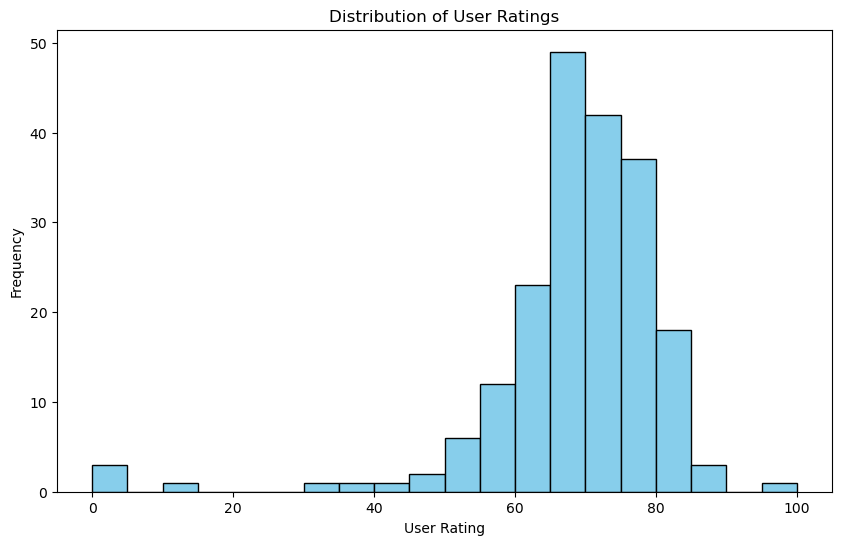

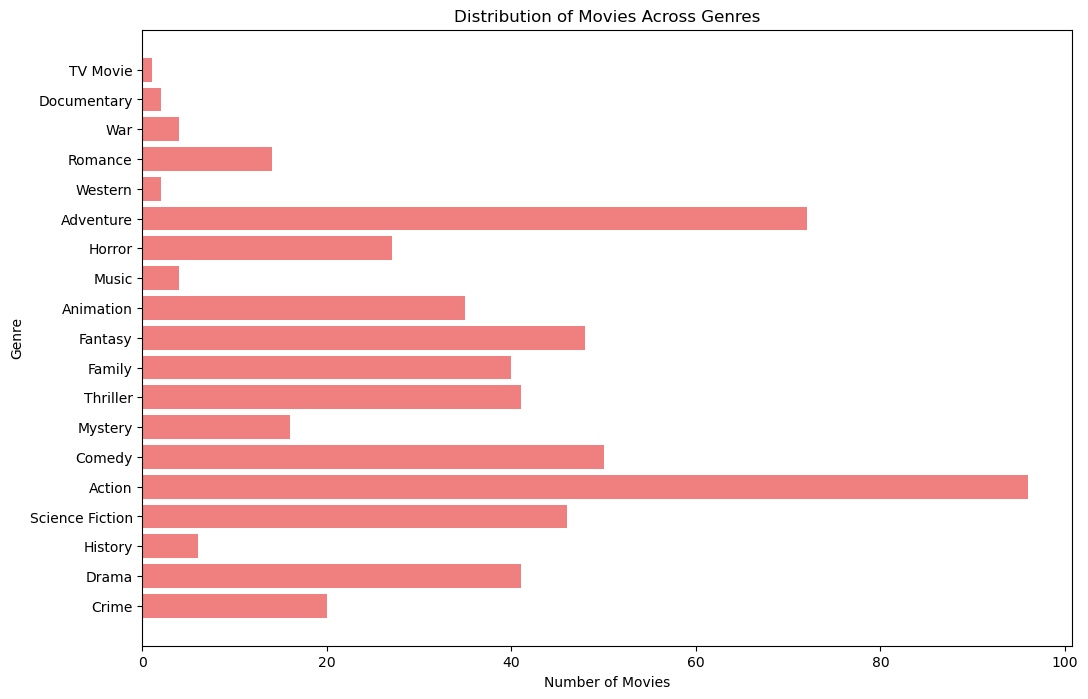

/Users/youjunghong/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/youjunghong/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/youjunghong/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/youjunghong/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/youjunghong/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46988 (\N{HANGUL SYLLABLE RAM}) missing from current

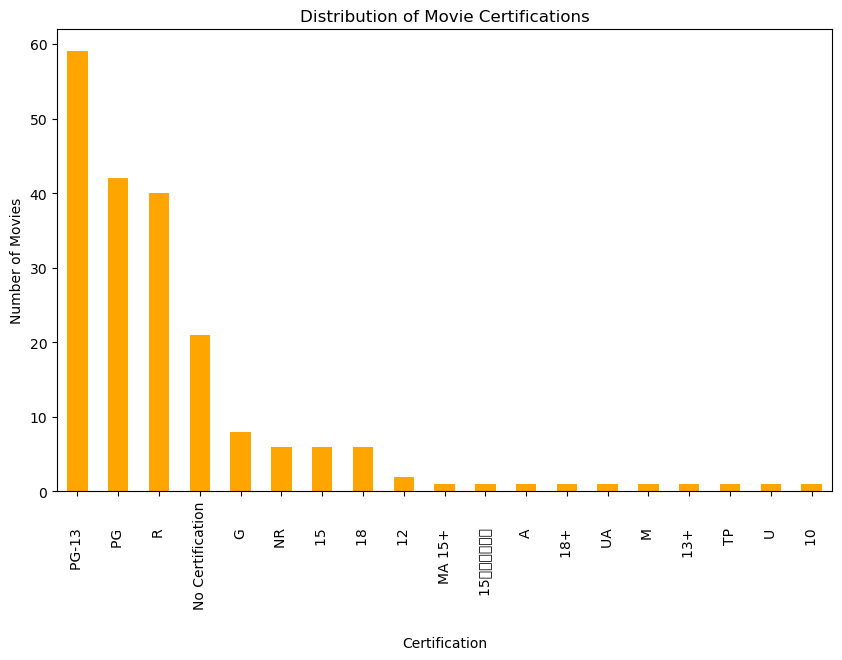

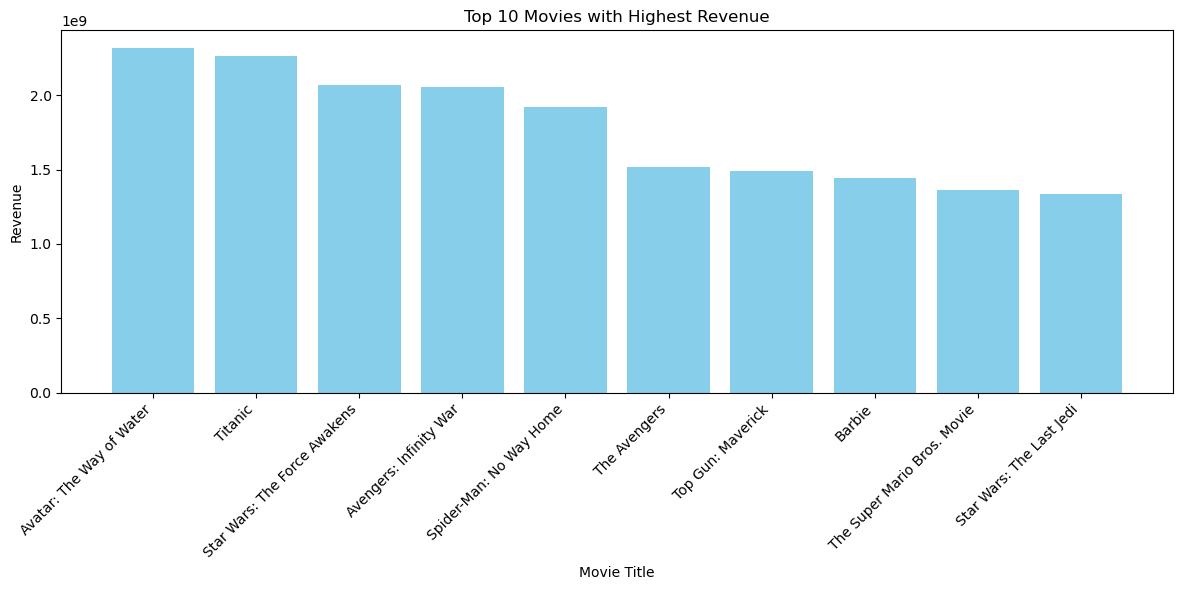

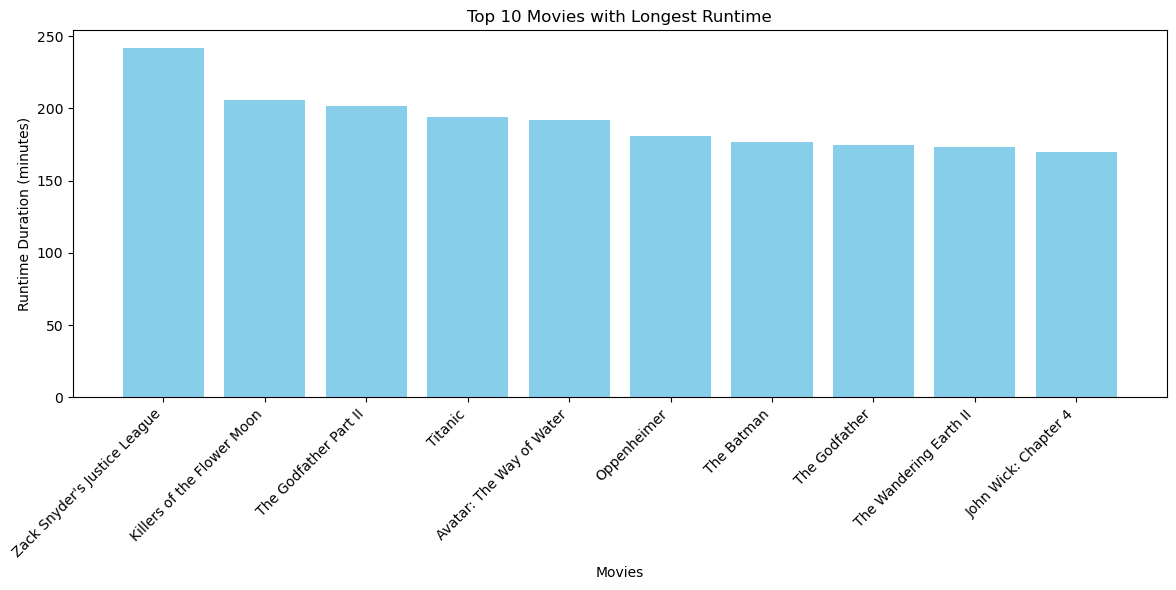

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

plt.figure(figsize=(10, 6))
plt.hist(final_df['User_rating'].astype(float), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of User Ratings')
plt.xlabel('User Rating')
plt.ylabel('Frequency')
plt.show()

genre_counter = Counter(genre for genres in final_df['Genre'] for genre in eval(genres))

plt.figure(figsize=(12, 8))
plt.barh(list(genre_counter.keys()), list(genre_counter.values()), color='lightcoral')
plt.title('Distribution of Movies Across Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

cert_counts = final_df['Certification'].value_counts()

plt.figure(figsize=(10, 6))
cert_counts.plot(kind='bar', color='orange')
plt.title('Distribution of Movie Certifications')
plt.xlabel('Certification')
plt.ylabel('Number of Movies')
plt.show()

import matplotlib.pyplot as plt

top_10_revenue = result_df.nlargest(10, 'Revenue')

plt.figure(figsize=(12, 6))
plt.bar(top_10_revenue['Title'], top_10_revenue['Revenue'], color='skyblue')
plt.xlabel('Movie Title')
plt.ylabel('Revenue')
plt.title('Top 10 Movies with Highest Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Displaying the bar chart
plt.show()


import matplotlib.pyplot as plt

result_df = result_df.sort_values(by="Runtime_Duration", ascending=False)

top_10_movies = result_df.head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_movies["Title"], top_10_movies["Runtime_Duration"], color='skyblue')
plt.xlabel('Movies')
plt.ylabel('Runtime Duration (minutes)')
plt.title('Top 10 Movies with Longest Runtime')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [228]:

top_10_revenue = result_df.nlargest(10, 'Revenue')

# Displaying the result
print("Top 10 Movies with Highest Revenue:")
print(top_10_revenue[['Title', 'Revenue']])

Top 10 Movies with Highest Revenue:
                            Title       Revenue
59       Avatar: The Way of Water  2.320250e+09
191                       Titanic  2.264162e+09
164  Star Wars: The Force Awakens  2.068224e+09
98         Avengers: Infinity War  2.052415e+09
64        Spider-Man: No Way Home  1.921847e+09
194                  The Avengers  1.518816e+09
117             Top Gun: Maverick  1.488733e+09
35                         Barbie  1.441800e+09
37    The Super Mario Bros. Movie  1.362000e+09
189      Star Wars: The Last Jedi  1.332699e+09


In [236]:
top_10_revenue = result_df.nlargest(10, 'Runtime_Duration')

# Displaying the result
print("Top 10 Movies with Longest Runtime:")
print(top_10_revenue[['Title', 'Runtime']])

Top 10 Movies with Longest Runtime:
                            Title Runtime
95   Zack Snyder's Justice League   4h 2m
0      Killers of the Flower Moon  3h 26m
178         The Godfather Part II  3h 22m
191                       Titanic  3h 14m
59       Avatar: The Way of Water  3h 12m
7                     Oppenheimer   3h 1m
149                    The Batman  2h 57m
182                 The Godfather  2h 55m
129        The Wandering Earth II  2h 53m
61           John Wick: Chapter 4  2h 50m


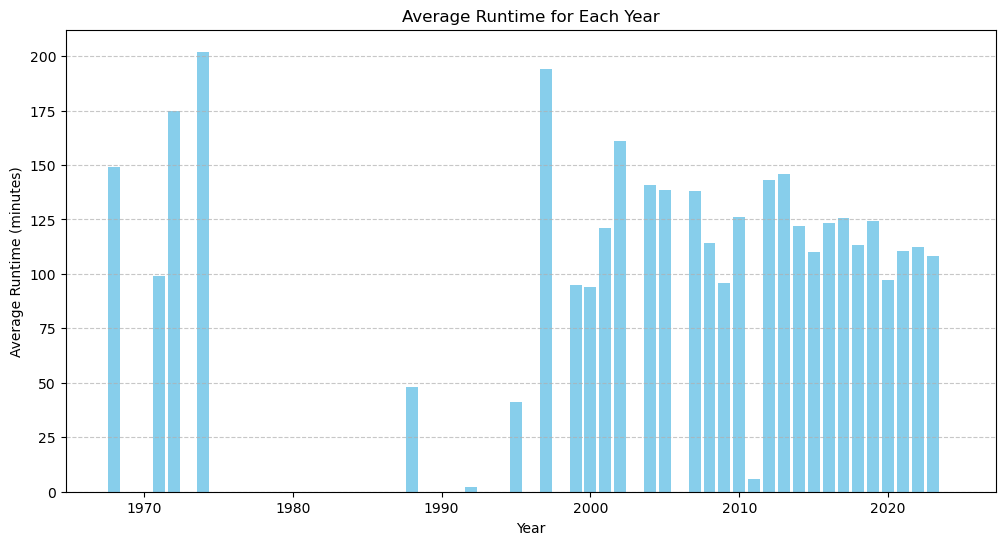

Average Runtime for Each Year:
    Year  Runtime_Duration
0   1968        149.000000
1   1971         99.000000
2   1972        175.000000
3   1974        202.000000
4   1988         48.000000
5   1992          2.000000
6   1995         41.000000
7   1997        194.000000
8   1999         95.000000
9   2000         94.000000
10  2001        121.000000
11  2002        161.000000
12  2004        141.000000
13  2005        138.333333
14  2007        138.000000
15  2008        114.333333
16  2009         96.000000
17  2010        126.333333
18  2011          6.000000
19  2012        143.000000
20  2013        146.000000
21  2014        122.000000
22  2015        110.000000
23  2016        123.500000
24  2017        125.600000
25  2018        113.200000
26  2019        124.250000
27  2020         97.000000
28  2021        110.562500
29  2022        112.400000
30  2023        108.333333
31  2024          0.000000


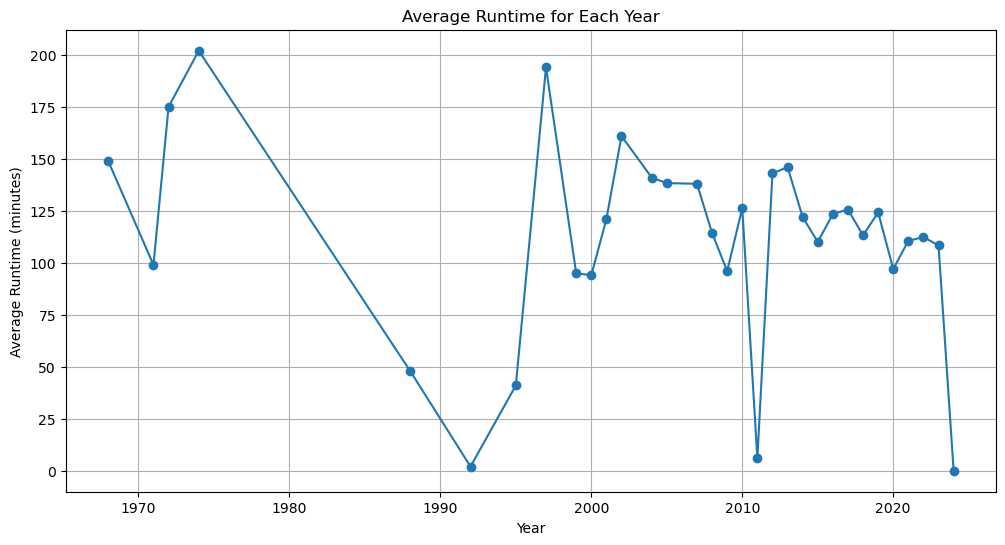

In [244]:
import pandas as pd
import matplotlib.pyplot as plt


print("Average Runtime for Each Year:")
print(average_runtime_per_year)

import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(average_runtime_per_year['Year'], average_runtime_per_year['Runtime_Duration'], marker='o', linestyle='-')
plt.title('Average Runtime for Each Year')
plt.xlabel('Year')
plt.ylabel('Average Runtime (minutes)')
plt.grid(True)
plt.show()
